
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names: Alireza ElmiFard, Mohammad BaniAhmadi, MohammadAli Meschi

Student Numbers:  </font>402106207, 402105751, 402106491

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [2]:
DATA_DIR = '/content/drive/MyDrive/massachusetts-roads-dataset'
IMAGE_SIZE = (256,256)
BATCH_SIZE = 8
NUM_WORKERS = 2
LR = 0.001
NUM_EPOCHS = 15

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [3]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'massachusetts-roads-dataset' dataset.
Path to dataset files: /kaggle/input/massachusetts-roads-dataset


If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [4]:
from google.colab import drive

drive.mount('/content/drive')

# shutil.move(path, '/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [5]:
def load_images_and_masks(image_paths, mask_paths, image_size):
    images, masks = [], []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and resize image
        img = Image.open(img_path).convert('RGB').resize(image_size)
        images.append(np.array(img))

        # Load and process mask
        mask = Image.open(mask_path).resize(image_size)
        mask_array = np.array(mask)
        binary_mask = np.where((mask_array == 0) | (mask_array == 1), 0, 1).astype(np.uint8)
        masks.append(binary_mask)

    return np.array(images), np.array(masks)


def get_image_mask_paths(image_dir, mask_dir, image_ext=".tiff", mask_ext=".tif"):
    # Extract base filenames
    image_names = {os.path.splitext(f)[0] for f in os.listdir(image_dir)}
    mask_names  = {os.path.splitext(f)[0] for f in os.listdir(mask_dir)}
    common_names = sorted(image_names & mask_names)

    # Build full paths
    image_paths = [os.path.join(image_dir, f + image_ext) for f in common_names]
    mask_paths  = [os.path.join(mask_dir,  f + mask_ext)  for f in common_names]

    return image_paths, mask_paths


# Paths
train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir  = os.path.join(DATA_DIR, 'tiff/train_labels')
val_images_dir   = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir    = os.path.join(DATA_DIR, 'tiff/val_labels')

# Get sorted and matched paths
train_image_paths, train_mask_paths = get_image_mask_paths(train_images_dir, train_masks_dir)
val_image_paths,   val_mask_paths   = get_image_mask_paths(val_images_dir,   val_masks_dir)

# Load data
train_images, train_masks = load_images_and_masks(train_image_paths, train_mask_paths, IMAGE_SIZE)
val_images,   val_masks   = load_images_and_masks(val_image_paths,   val_mask_paths,   IMAGE_SIZE)


### Data Visualization

Display the images and their masks for several samples.

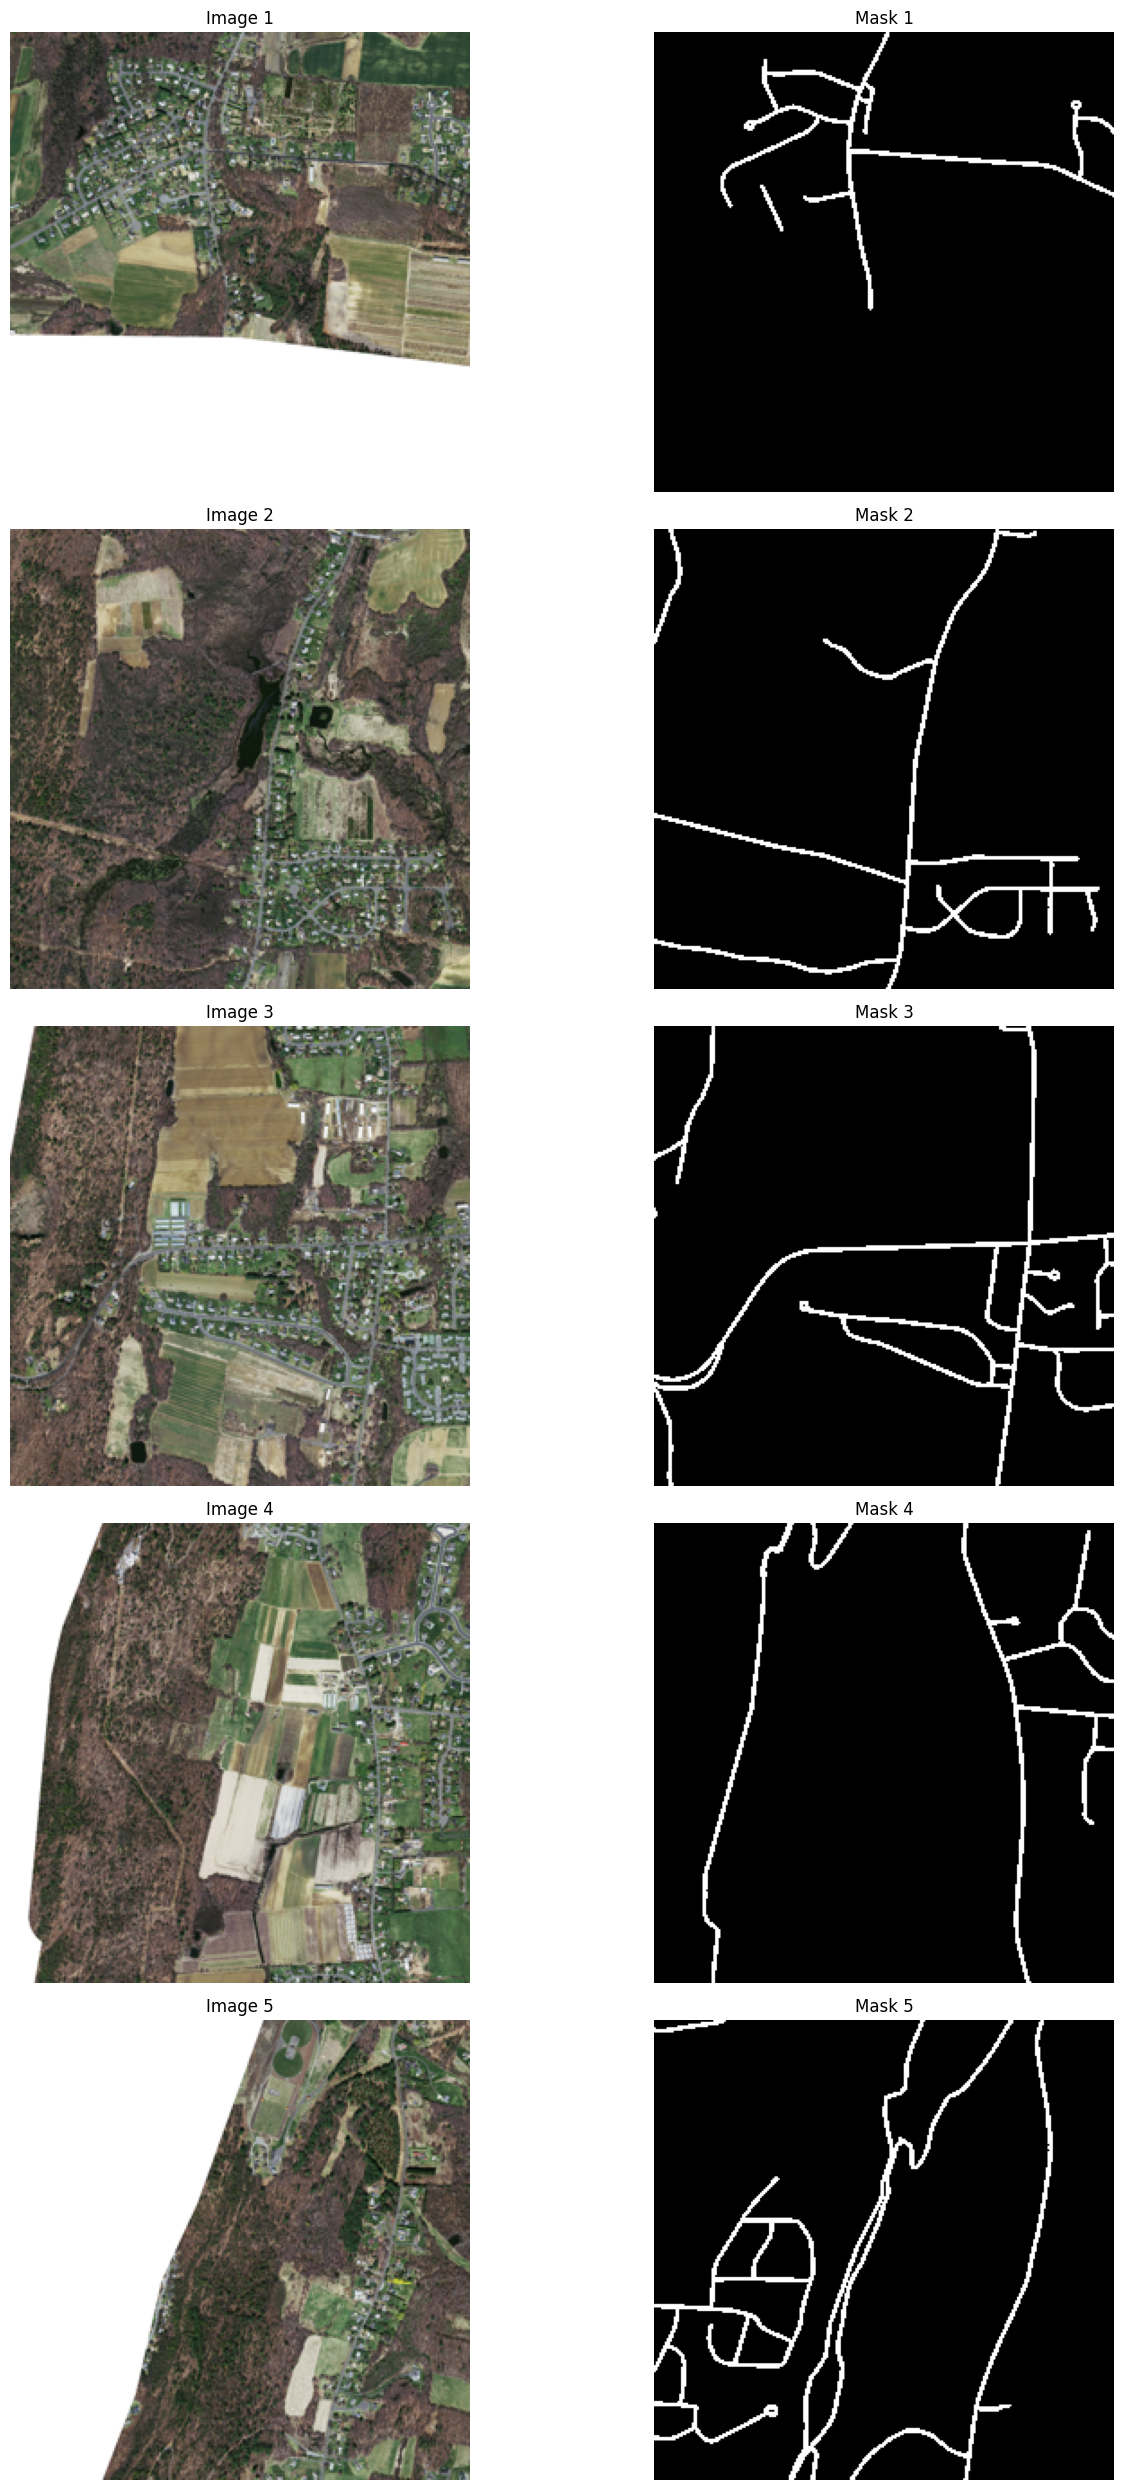

In [6]:

import matplotlib.pyplot as plt
import numpy as np

def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.

    Args:
        images (array-like): Collection of input images.
        masks (array-like): Collection of corresponding mask images.
        n (int): Number of image-mask pairs to display.
    """
    plt.figure(figsize=(15, 5 * n))

    # Ensure n doesn't exceed available samples
    n = min(n, len(images))

    for i in range(n):
        # Display image
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display mask
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# نمونه استفاده از تابع:
visualize_images_and_masks(train_images, train_masks, n=5)

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [7]:
class RoadDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask  = self.masks[idx]

        image = Image.fromarray(image)
        mask  = Image.fromarray(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0).long()),
])

train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of multiple layers (e.g., Conv2D, BatchNorm, ReLU).

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [9]:
class UpConvBlock(nn.Module):
    """
    An upsampling block used in decoder parts of segmentation networks like U-Net.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    """
    U-Net architecture for image segmentation tasks.

    Args:
        in_channel (int): Number of input channels (e.g., 3 for RGB images).
        out_channel (int): Number of output channels (e.g., 1 for binary segmentation).
        filter (list): List of filter sizes for each level of the encoder/decoder.
    """
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()

        # Encoder (Contracting Path)
        self.encoder = nn.ModuleList()
        for i in range(len(filter)):
            if i == 0:
                self.encoder.append(ConvBlock(in_channel, filter[i]))
            else:
                self.encoder.append(ConvBlock(filter[i-1], filter[i]))

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = ConvBlock(filter[-1], filter[-1] * 2)

        # Decoder (Expansive Path)
        self.decoder = nn.ModuleList()
        self.upconvs = nn.ModuleList()
        for i in range(len(filter)-1, -1, -1):
            if i == len(filter)-1:
                self.upconvs.append(UpConvBlock(filter[-1] * 2, filter[i]))
            else:
                self.upconvs.append(UpConvBlock(filter[i+1], filter[i]))

            if i == 0:
                self.decoder.append(ConvBlock(filter[i] * 2, filter[i]))
            else:
                self.decoder.append(ConvBlock(filter[i] * 2, filter[i]))

        # Final convolution
        self.final_conv = nn.Conv2d(filter[0], out_channel, kernel_size=1)

        # Store filter sizes for forward pass
        self.filter = filter

    def _pad_to_match(self, x, ref):
        diff_y = ref.size(2) - x.size(2)
        diff_x = ref.size(3) - x.size(3)
        if diff_x != 0 or diff_y != 0:
            x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                          diff_y // 2, diff_y - diff_y // 2])
        return x

    def forward(self, x):
        # Encoder
        skip_connections = []
        for i, enc in enumerate(self.encoder):
            x = enc(x)
            skip_connections.append(x)
            if i < len(self.encoder) - 1:  # Don't pool after the last encoder block
                x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]  # Reverse skip connections
        for i, (upconv, dec) in enumerate(zip(self.upconvs, self.decoder)):
            x = upconv(x)
            # Pad to match skip connection size
            x = self._pad_to_match(x, skip_connections[i])
            # Concatenate with skip connection
            x = torch.cat([x, skip_connections[i]], dim=1)
            x = dec(x)

        # Final convolution
        x = self.final_conv(x)

        return x

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [11]:
class AttentionBlock(nn.Module):

    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int),
        )

        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int),
        )

        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.act(g1 + x1)
        psi = self.psi(psi)
        return x * psi

Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionUNet(UNet):
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)
        self.filter_sizes = filter_sizes

        # Attention blocks for each decoder level
        self.attention_blocks = nn.ModuleList([
            AttentionBlock(f_g=filter_sizes[i], f_l=filter_sizes[i], f_int=filter_sizes[i] // 2)
            for i in range(len(filter_sizes)-1, -1, -1)
        ])

    def forward(self, x):
        # Encoder
        skip_connections = []
        for i, enc in enumerate(self.encoder):
            x = enc(x)
            skip_connections.append(x)
            if i < len(self.encoder) - 1:  # Don't pool after the last encoder
                x = self.pool(x)  # Use single pool layer from UNet

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]  # Reverse skip connections
        for i, (upconv, att, dec) in enumerate(zip(self.upconvs, self.attention_blocks, self.decoder)):
            x = upconv(x)
            x = self._pad_to_match(x, skip_connections[i])
            x_att = att(x, skip_connections[i])
            x = dec(torch.cat([x_att, x], dim=1))

        # Final convolution
        return self.final_conv(x)

# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [13]:
import torch.nn as nn

class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel),
        ) if in_channel != out_channel else nn.Identity()

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.shortcut(x)
        return self.act(out)

Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [14]:
class ResidualAttentionUNet(nn.Module):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__()

        self.filter_sizes = filter_sizes

        # Encoder (ResidualConvBlock)
        self.encoder = nn.ModuleList()
        for i in range(len(filter_sizes)):
            if i == 0:
                self.encoder.append(ResidualConvBlock(in_channel, filter_sizes[i]))
            else:
                self.encoder.append(ResidualConvBlock(filter_sizes[i-1], filter_sizes[i]))

        # Pooling layers
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(len(filter_sizes)-1)])

        # Bottleneck
        self.bottleneck = ResidualConvBlock(filter_sizes[-1], filter_sizes[-1] * 2)

        # Decoder upconvs
        self.upconvs = nn.ModuleList()
        for i in range(len(filter_sizes)-1, -1, -1):
            if i == len(filter_sizes)-1:
                self.upconvs.append(nn.ConvTranspose2d(filter_sizes[-1] * 2, filter_sizes[i], 2, 2))
            else:
                self.upconvs.append(nn.ConvTranspose2d(filter_sizes[i+1], filter_sizes[i], 2, 2))

        # Attention blocks
        self.attention_blocks = nn.ModuleList()
        for i in range(len(filter_sizes)-1, -1, -1):
            self.attention_blocks.append(AttentionBlock(filter_sizes[i], filter_sizes[i], filter_sizes[i] // 2))

        # Decoder residual blocks
        self.decoder = nn.ModuleList()
        for i in range(len(filter_sizes)-1, -1, -1):
            if i == 0:
                self.decoder.append(ResidualConvBlock(filter_sizes[i] * 2, filter_sizes[i]))
            else:
                self.decoder.append(ResidualConvBlock(filter_sizes[i] * 2, filter_sizes[i]))

        self.final_conv = nn.Conv2d(filter_sizes[0], out_channel, 1)

    def forward(self, x):
        # Encoder
        skip_connections = []
        for i, enc in enumerate(self.encoder):
            x = enc(x)
            skip_connections.append(x)
            if i < len(self.encoder) - 1:
                x = self.pools[i](x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for i, (upconv, att, dec) in enumerate(zip(self.upconvs, self.attention_blocks, self.decoder)):
            x = upconv(x)
            # Handle size mismatches
            if x.shape[2:] != skip_connections[i].shape[2:]:
                x = F.interpolate(x, size=skip_connections[i].shape[2:], mode='bilinear', align_corners=True)

            att_map = att(x, skip_connections[i])
            x = torch.cat([att_map, x], dim=1)
            x = dec(x)

        return self.final_conv(x)

# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [15]:

class DiceLoss(nn.Module):

    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.contiguous().view(pred.size(0), -1)
        real = real.contiguous().view(real.size(0), -1)

        intersection = (pred * real).sum(dim=1)
        denom = pred.sum(dim=1) + real.sum(dim=1)

        dice_coeff = (2.0 * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice_coeff.mean()

class IouLoss(nn.Module):

    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.contiguous().view(pred.size(0), -1)
        real = real.contiguous().view(real.size(0), -1)

        intersection = (pred * real).sum(dim=1)
        union = pred.sum(dim=1) + real.sum(dim=1) - intersection

        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou_coeff.mean()


class OverallLoss(nn.Module):

    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [16]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    total_loss = 0.0
    model.train()

    for i, (img, mask) in enumerate(tqdm(data_loader)):
        img = img.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32)
        mask = mask.unsqueeze(1)

        optimizer.zero_grad()

        pred = model(img)
        pred = torch.sigmoid(pred)
        _, _, _, loss = criterion(pred, mask)

        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


Design a function for evaluation after each training phase.

In [17]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            img = img.to(device, dtype=torch.float32)
            mask = mask.to(device, dtype=torch.float32).unsqueeze(1)
            pred = torch.sigmoid(model(img))
            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)
            total_loss += overall_loss.item()
            iou_score += 1 - iou_loss.item()
            dice_score += 1 - dice_loss.item()
        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score


# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

Now do the same for Attention UNet and Reidual Attention UNet.

In [18]:
unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)
# Add a scheduler if you like

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")




100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Iteration 1/15: Train Loss: 1.64 | Val Loss: 1.20 | Iou Score: 0.45 | Dice Score: 0.62


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Iteration 2/15: Train Loss: 1.20 | Val Loss: 0.93 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Iteration 3/15: Train Loss: 1.13 | Val Loss: 0.87 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Iteration 4/15: Train Loss: 1.08 | Val Loss: 0.92 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Iteration 5/15: Train Loss: 1.06 | Val Loss: 0.83 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Iteration 6/15: Train Loss: 1.04 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Iteration 7/15: Train Loss: 1.02 | Val Loss: 0.82 | Iou Score: 0.62 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Iteration 8/15: Train Loss: 1.02 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Iteration 9/15: Train Loss: 0.98 | Val Loss: 0.81 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Iteration 10/15: Train Loss: 0.99 | Val Loss: 0.78 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


Iteration 11/15: Train Loss: 0.97 | Val Loss: 0.76 | Iou Score: 0.65 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


Iteration 12/15: Train Loss: 0.97 | Val Loss: 0.77 | Iou Score: 0.65 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Iteration 13/15: Train Loss: 0.96 | Val Loss: 0.75 | Iou Score: 0.65 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Iteration 14/15: Train Loss: 0.95 | Val Loss: 0.77 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

Iteration 15/15: Train Loss: 0.94 | Val Loss: 0.77 | Iou Score: 0.65 | Dice Score: 0.78


In [19]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Iteration 1/15: Train Loss: 1.74 | Val Loss: 1.21 | Iou Score: 0.46 | Dice Score: 0.62


100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Iteration 2/15: Train Loss: 1.24 | Val Loss: 0.98 | Iou Score: 0.55 | Dice Score: 0.70


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Iteration 3/15: Train Loss: 1.14 | Val Loss: 0.94 | Iou Score: 0.57 | Dice Score: 0.73


100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


Iteration 4/15: Train Loss: 1.09 | Val Loss: 1.02 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


Iteration 5/15: Train Loss: 1.07 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Iteration 6/15: Train Loss: 1.04 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


Iteration 7/15: Train Loss: 1.03 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


Iteration 8/15: Train Loss: 1.04 | Val Loss: 0.93 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Iteration 9/15: Train Loss: 1.01 | Val Loss: 0.78 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Iteration 10/15: Train Loss: 0.99 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Iteration 11/15: Train Loss: 0.98 | Val Loss: 0.75 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


Iteration 12/15: Train Loss: 0.96 | Val Loss: 0.79 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Iteration 13/15: Train Loss: 0.97 | Val Loss: 0.76 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


Iteration 14/15: Train Loss: 0.96 | Val Loss: 0.75 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Iteration 15/15: Train Loss: 0.95 | Val Loss: 0.74 | Iou Score: 0.66 | Dice Score: 0.79


For Residual Attention UNet, plot the changes in train and validation loss.

In [20]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


Iteration 1/15: Train Loss: 1.55 | Val Loss: 1.08 | Iou Score: 0.51 | Dice Score: 0.67


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Iteration 2/15: Train Loss: 1.19 | Val Loss: 0.97 | Iou Score: 0.56 | Dice Score: 0.71


100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Iteration 3/15: Train Loss: 1.11 | Val Loss: 0.87 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Iteration 4/15: Train Loss: 1.08 | Val Loss: 0.82 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


Iteration 5/15: Train Loss: 1.04 | Val Loss: 0.79 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Iteration 6/15: Train Loss: 1.03 | Val Loss: 0.82 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


Iteration 7/15: Train Loss: 1.00 | Val Loss: 0.76 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Iteration 8/15: Train Loss: 0.99 | Val Loss: 0.79 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


Iteration 9/15: Train Loss: 0.98 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


Iteration 10/15: Train Loss: 0.97 | Val Loss: 0.76 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


Iteration 11/15: Train Loss: 0.96 | Val Loss: 0.73 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


Iteration 12/15: Train Loss: 0.94 | Val Loss: 0.74 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Iteration 13/15: Train Loss: 0.94 | Val Loss: 0.74 | Iou Score: 0.66 | Dice Score: 0.79


100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Iteration 14/15: Train Loss: 0.92 | Val Loss: 0.73 | Iou Score: 0.67 | Dice Score: 0.80


100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Iteration 15/15: Train Loss: 0.92 | Val Loss: 0.74 | Iou Score: 0.66 | Dice Score: 0.79


Now Visualize losses.

In [21]:
# Plot the losses

### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

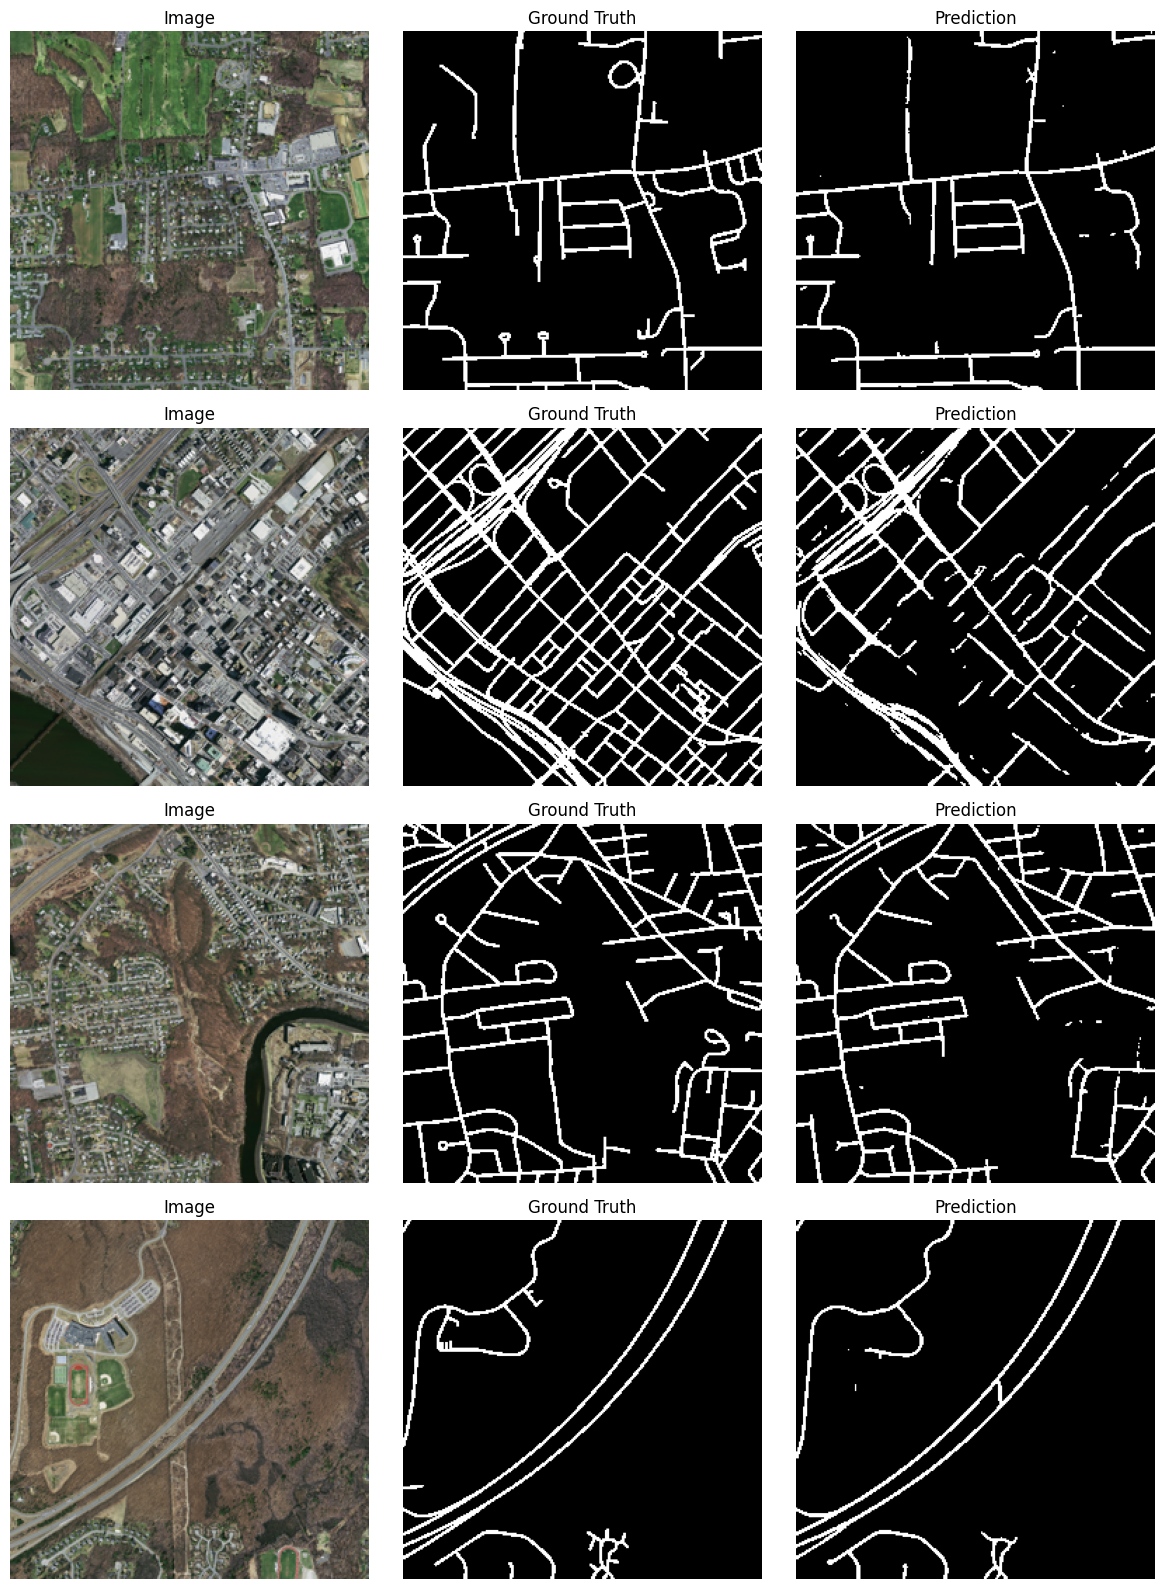

In [22]:
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def visualize_image_mask_prediction(images, masks, predictions, n=5, mean=MEAN, std=STD):
    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        img = images[i]
        mask = masks[i]
        pred = predictions[i]

        # Convert tensors to numpy arrays
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()
        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()
        if isinstance(pred, torch.Tensor):
            pred = pred.detach().cpu().numpy()

        # Handle channel-first format
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = np.transpose(img, (1, 2, 0))

        # Denormalize image
        img = img.astype(np.float32)
        if img.ndim == 3 and img.shape[2] == 3:
            img = img * std + mean
        if img.max() <= 1.0 + 1e-6:
            img = img * 255.0
        img = np.clip(img, 0, 255).astype(np.uint8)

        # Squeeze mask and prediction if needed
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask[0]
        if pred.ndim == 3 and pred.shape[0] == 1:
            pred = pred[0]

        # Binarize prediction
        pred_bin = (pred > 0.5).astype(np.uint8)

        # Plot image
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        # Plot ground truth mask
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # Plot predicted mask
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(pred_bin, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

imgs, gt_masks = next(iter(val_loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = torch.sigmoid(unet(imgs))

visualize_image_mask_prediction(
    images=imgs.cpu(),
    masks=gt_masks.cpu(),
    predictions=preds.cpu(),
    n=4,
    mean=MEAN, std=STD
)
